In [1]:
# Imports
import os
import torch
import numpy as np

# Training/Test Set Creation 
from sklearn.model_selection import StratifiedShuffleSplit

# Dataset Creation
from torch.utils.data import Dataset, DataLoader, Subset
import torchvision.transforms as transforms

# RNN Prediction and Result Visualization
from torch import nn
from sklearn.metrics import classification_report, confusion_matrix

# Results Plotting
import matplotlib.pyplot as plt

# Create Training and Test Sets

## Define classes and preview

In [2]:
# Define label dictionary - 20 classes
syncs = [  "0-100 ms", "101-200 ms", "201-300 ms", "301-400 ms", "401-500 ms", 
         "501-600 ms", "601-700 ms", "701-800 ms", "801-900 ms", "901-1000 ms" ]
sync_dict = {}

count = 0
for sync_val in syncs:
    sync_dict[sync_val] = count
    count += 1

# preview dictionary
sync_dict

{'0-100 ms': 0,
 '101-200 ms': 1,
 '201-300 ms': 2,
 '301-400 ms': 3,
 '401-500 ms': 4,
 '501-600 ms': 5,
 '601-700 ms': 6,
 '701-800 ms': 7,
 '801-900 ms': 8,
 '901-1000 ms': 9}

## Load training data

In [3]:
# Construct X = folder names, y = the label

feature_folder = 'sync_measure_data/features_v1'

X_paths = [] # paths to feature files
y = []       # designated label

for file_name in os.listdir(feature_folder):

    X_paths.append(feature_folder + '/' + file_name)

    # extracting class label from the file name
    #
    label = int(file_name.split('.')[0].split("_")[-1])

    y.append(label)

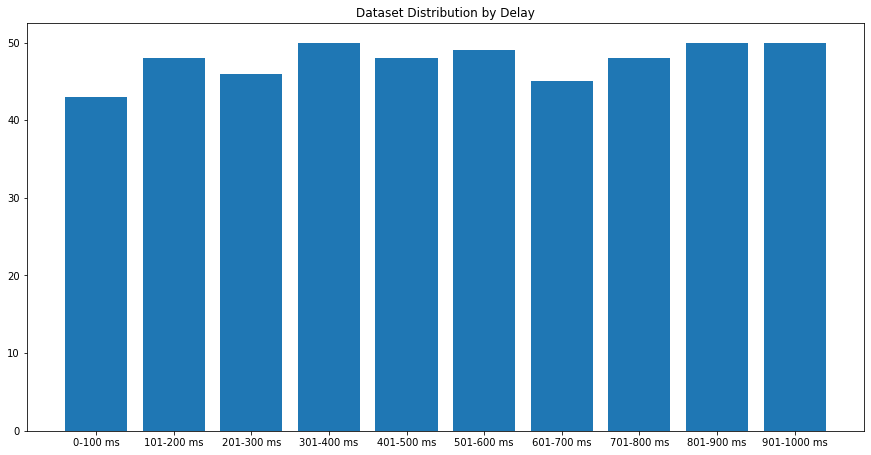

In [4]:
# Preview Data distribution
from collections import Counter
video_counter = Counter(y)

fig, axes = plt.subplots(1,1, figsize=(15,7.5))
plt.bar(video_counter.keys(), video_counter.values())
plt.xticks(range(0,10), syncs)
plt.title("Dataset Distribution by Delay")
plt.show()

In [5]:
# Split into training and test sets
splitter = StratifiedShuffleSplit(n_splits = 2, test_size = 0.2, random_state = 0)
train_set, test_set = next(splitter.split(X_paths, y))

# Training Set
train_X_paths = [X_paths[i] for i in train_set]
train_ys = [y[i] for i in train_set]
print("Training Set: ({0},{1})".format(len(train_X_paths), len(train_ys)))

# Test Set
test_X_paths = [X_paths[i] for i in test_set]
test_ys = [y[i] for i in test_set]
print("Test Set: ({0},{1})".format(len(test_X_paths), len(test_ys)))

Training Set: (381,381)
Test Set: (96,96)


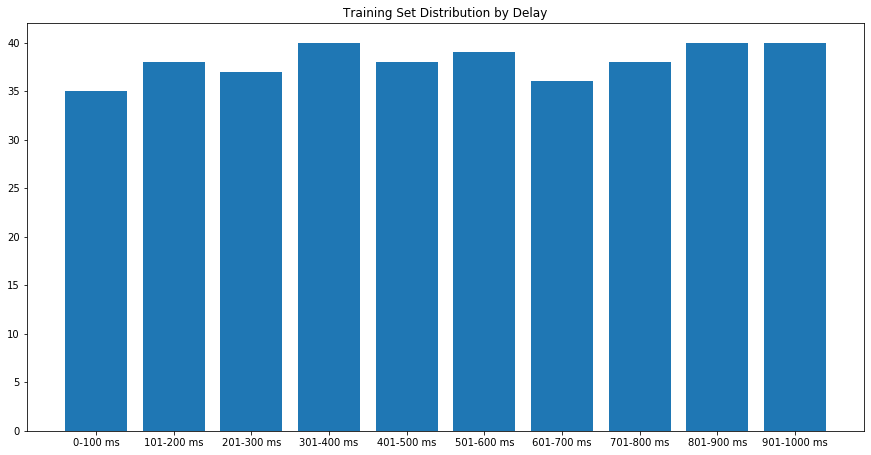

In [6]:
train_counter = Counter(train_ys)

fig, axes = plt.subplots(1,1, figsize=(15,7.5))
plt.bar(train_counter.keys(), train_counter.values())
plt.xticks(range(0,10), syncs)
plt.title("Training Set Distribution by Delay")
plt.show()

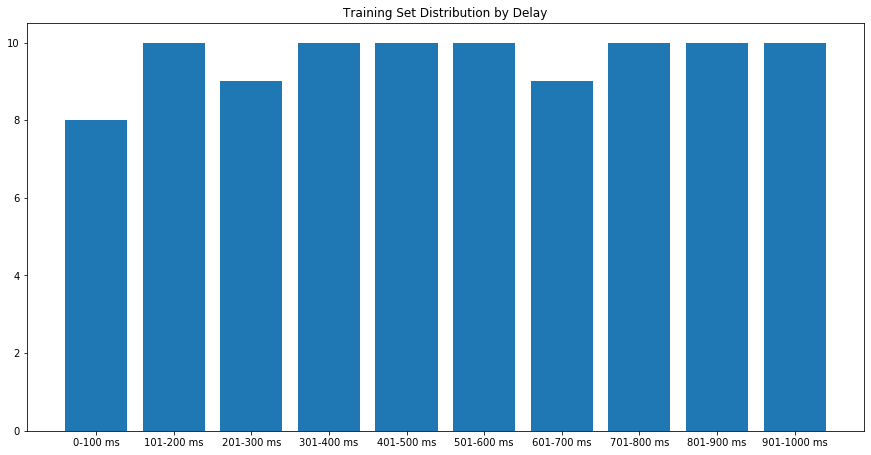

In [7]:
test_counter = Counter(test_ys)

fig, axes = plt.subplots(1,1, figsize=(15,7.5))
plt.bar(test_counter.keys(), test_counter.values())
plt.xticks(range(0,10), syncs)
plt.title("Training Set Distribution by Delay")
plt.show()

# Create Pytorch Dataset

In [8]:
# Set seeds for reproducibility
np.random.seed(4139)
torch.manual_seed(4139)

In [9]:
# Create Dataset Class
class SyncDataset(Dataset):
    
    def __init__(self, X, y, transform=None):
        self.transform = transform
        self.X = X
        self.y = y

    # Returns length
    def __len__(self):
        return len(self.X)

    # Returns X feature array and y value
    def __getitem__(self, idx):
        
        # Load npz file
        with np.load(self.X[idx]) as data:
            X_feat = data['features']
        
        # Convert X to tensor
        X_tensor = torch.from_numpy(X_feat).float()
        
        return X_tensor, self.y[idx]

In [10]:
# Define Training Dataset 
training_dataset = SyncDataset(X = train_X_paths, y = train_ys)
print(len(training_dataset))

# Define Test Dataset
testing_dataset = SyncDataset(X = test_X_paths, y = test_ys)
print(len(testing_dataset))

# number of features per frame
num_features = training_dataset[0][0].shape[1]

print('num_features:', num_features)

381
96
num_features: 33


# Model Definition 

In [11]:
class SyncRNN(nn.Module):
    
    def __init__(self, params_model):
        
        super(SyncRNN, self).__init__()
        
        # Import Model Parameters
        num_classes = params_model["num_classes"]
        rnn_hidden_size = params_model["rnn_hidden_size"]
        rnn_num_layers = params_model["rnn_num_layers"]
        batchsize = 1
        
        # Define Model Structure
        self.rnn = nn.LSTM(num_features, rnn_hidden_size, rnn_num_layers)
        self.fc1 = nn.Linear(rnn_hidden_size, num_classes)
        
    def forward(self, x):
        
        # batch count, frame count, feature size
        frame_count, feature_size = x.shape
        frame_idx = 0
        
        # Reshape the frame
        shaped_frame = x[frame_idx].view(1, 1, feature_size)
        
        # Feed the first frame into the rnn
        output, (hn, cn) = self.rnn(shaped_frame)
        
        # Feed the rest of the frames 
        for frame_idx in range(1, frame_count):
            shaped_frame = x[frame_idx].view(1, 1, feature_size)
            output, (hn, cn) = self.rnn(shaped_frame, (hn, cn))
        
        output = self.fc1(output)
        
        return output

# Model Testing

In [12]:
# Setup model with parameters
model_params = {
    "num_classes": 10,
    "rnn_num_layers": 1,
    "rnn_hidden_size": 200,
}
model = SyncRNN(model_params)

In [13]:
# Load the weights and set to GPU
weight_path = "./models/weights_ebf_classifier.pt" # model from Stage 2
#weight_path = "./models/EBF Classifiers/weights_ebf_classifier_E20.pt" # pre-trained EBF at 20 epochs 

if torch.cuda.is_available():
    model.load_state_dict(torch.load(weight_path))
    device = torch.device("cuda:0")
else: 
    model.load_state_dict(torch.load(weight_path, map_location = lambda storage, location:storage))
    device = torch.device("cpu")

model = model.to(device)

## Training Set Results

In [14]:
ytrain_predictions = []
ytrain_actual = []
model.eval()
with torch.no_grad():
    count = 0
    correct_count = 0
    for train_X, train_y in training_dataset:
        output = model(train_X.to(device)).cpu()
        train_pred = output.argmax().item()
        ytrain_predictions.append(train_pred)
        ytrain_actual.append(train_y)
        #print("{}. Predicted: {} Actual: {}".format(count, train_pred, train_y))
        if train_pred == train_y:
            correct_count += 1
        count += 1
print("Total Score: {0}/453 = {1:.2f}%".format(correct_count, (correct_count/453)*100))

Total Score: 77/453 = 17.00%


In [15]:
# Classification Report
print(classification_report(ytrain_predictions, ytrain_actual))

              precision    recall  f1-score   support

           0       0.03      0.50      0.05         2
           1       0.66      0.12      0.20       206
           2       0.11      0.31      0.16        13
           3       0.17      0.58      0.27        12
           4       0.16      0.22      0.18        27
           5       0.21      0.25      0.23        32
           6       0.14      0.38      0.20        13
           7       0.18      0.50      0.27        14
           8       0.23      0.20      0.21        46
           9       0.12      0.31      0.18        16

    accuracy                           0.20       381
   macro avg       0.20      0.34      0.20       381
weighted avg       0.44      0.20      0.21       381



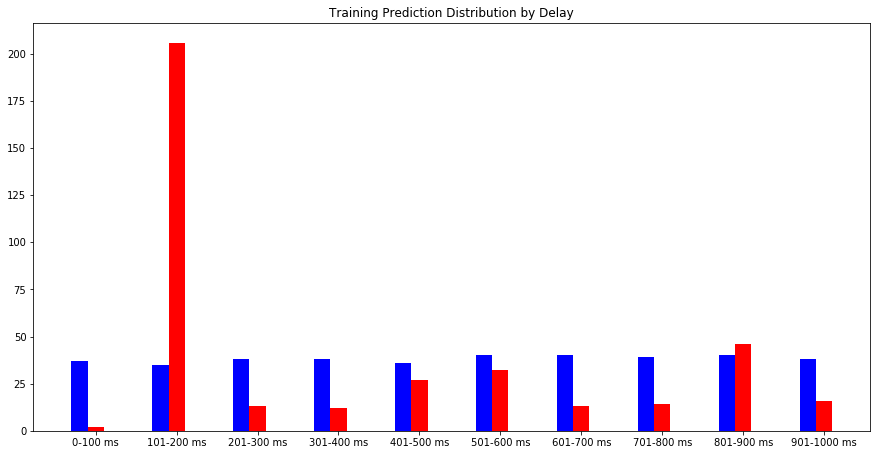

In [16]:
# Display Classifier Distribution
train_counter = Counter(train_ys)
train_counter_model = Counter(ytrain_predictions)
xbins = np.arange(0,10,1.0)

fig, axes = plt.subplots(1,1, figsize=(15,7.5))
plt.bar(xbins-0.2, train_counter.values(), width=0.2, color='b', align='center')
plt.bar(train_counter_model.keys(), train_counter_model.values(), width=0.2, color='r', align='center')

plt.xticks(range(0,10), syncs)
plt.title("Training Prediction Distribution by Delay")
plt.show()

## Test Set Results

In [17]:
ytest_predictions = []
ytest_actual = []
model.eval()
with torch.no_grad():
    count = 0
    correct_count = 0
    for test_X, test_y in testing_dataset:
        output = model(test_X.to(device)).cpu()
        test_pred = output.argmax().item()
        ytest_predictions.append(test_pred)
        ytest_actual.append(test_y)
        #print("{}. Predicted: {} Actual: {}".format(count, test_pred, test_y))
        if test_pred == test_y:
            correct_count += 1
        count += 1
print("Total Score: {0}/51 = {1:.2f}%".format(correct_count, (correct_count/51)*100))

Total Score: 15/51 = 29.41%


In [18]:
# Classification Report
print(classification_report(ytest_predictions, ytest_actual))

              precision    recall  f1-score   support

           0       0.12      1.00      0.22         1
           1       0.80      0.14      0.23        59
           2       0.11      0.33      0.17         3
           3       0.10      1.00      0.18         1
           4       0.10      0.20      0.13         5
           5       0.10      0.14      0.12         7
           6       0.11      0.25      0.15         4
           7       0.00      0.00      0.00         1
           8       0.10      0.09      0.10        11
           9       0.00      0.00      0.00         4

    accuracy                           0.16        96
   macro avg       0.15      0.32      0.13        96
weighted avg       0.53      0.16      0.18        96



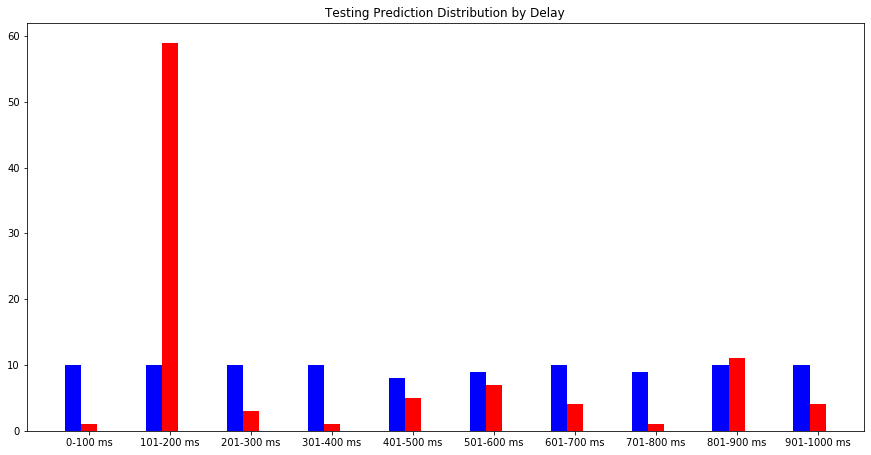

In [19]:
test_counter = Counter(test_ys)
test_counter_model = Counter(ytest_predictions)
xbins = np.arange(0,10,1.0)

fig, axes = plt.subplots(1,1, figsize=(15,7.5))
plt.bar(xbins-0.2, test_counter.values(), width=0.2, color='b', align='center')
plt.bar(test_counter_model.keys(), test_counter_model.values(), width=0.2, color='r', align='center')
plt.xticks(range(0,10), syncs)
plt.title("Testing Prediction Distribution by Delay")
plt.show()